In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('covid_us.csv')
df.drop(labels = "Unnamed: 0", axis = 1, inplace = True)

In [2]:
df.shape

(26992, 36)

In [3]:
df_American_Samoa = df[df['subregion1_name'] == 'American Samoa'].index.tolist()
df_District_of_Columbia = df[df['subregion1_name'] == 'District of Columbia'].index.tolist()
df_Guam = df[df['subregion1_name'] == 'Guam'].index.tolist()
df_Northern_Mariana_Islands = df[df['subregion1_name'] == 'Northern Mariana Islands'].index.tolist()
df_Puerto_Rico = df[df['subregion1_name'] == 'Puerto Rico'].index.tolist()
df_Virgin_Islands = df[df['subregion1_name'] == 'Virgin Islands'].index.tolist()
df.drop(df_American_Samoa, inplace = True)
df.drop(df_District_of_Columbia, inplace = True)
df.drop(df_Guam, inplace = True)
df.drop(df_Northern_Mariana_Islands, inplace = True)
df.drop(df_Puerto_Rico, inplace = True)
df.drop(df_Virgin_Islands, inplace = True)


#remove all subregion1_name not in 50 states

In [4]:
x = sorted(df['subregion1_name'].unique())
d = {'states' : x}
us_states = pd.DataFrame(data = d)

df = df.sort_values(['subregion1_name', 'date'])
df.reset_index(inplace = True)



In [5]:
df['total_confirmed'] = df['total_confirmed'].fillna(0)               #Replace NA with 0 for total confirmed column
df['total_confirmed'] = df['total_confirmed'].astype(np.int64)
#df['subregion1_name'] = df['subregion1_name'].astype(pd.StringDtype())   #convert subregion1_name to string types

In [6]:
new_date = []
for i in range(df.shape[0]):
    new_date.append(int("".join(df.loc[i, 'date'].split('-'))))
new_date
df['new_date'] = new_date
df.head()
#df.dtypes


,index,date,country_name,subregion1_name,locality_name,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,...,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_89,population_age_90_99,population_age_80_and_older,new_date
0,482,2020-01-01,United States of America,Alabama,NaN,NaN,NaN,NaN,NaN,0,...,701742.0,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200101
1,483,2020-01-02,United States of America,Alabama,NaN,NaN,NaN,NaN,NaN,0,...,701742.0,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200102
2,484,2020-01-03,United States of America,Alabama,NaN,NaN,NaN,NaN,NaN,0,...,701742.0,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200103
3,485,2020-01-04,United States of America,Alabama,NaN,NaN,NaN,NaN,NaN,0,...,701742.0,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200104
4,486,2020-01-05,United States of America,Alabama,NaN,NaN,NaN,NaN,NaN,0,...,701742.0,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200105


In [7]:
i = 1
ndays = []
for n in range(df.shape[0]):
    if i == 483:
        i = 1
        ndays.append(i)
        i +=1
    else: 
        ndays.append(i)
        i += 1
df['ndays'] = ndays


In [8]:
states_by_indices = []
i = 0

for n in range(df.shape[0]):
    if df.loc[n, 'subregion1_name'] == us_states.loc[i, 'states']:
        states_by_indices.append(i)
    else:
        i += 1
        states_by_indices.append(i)
        
states_by_indices



dict = {}
for i in us_states['states']:
    dict["df_{0}".format(i)] = df[df['subregion1_name'] == i]            #store the df_states inside a dictionary
                                                                         #key is df_states, value is the dataframe associated with that state
#dict["df_West Virginia"]                                                 #example: dict["df_West Virginia"] gets the dataframe for all rows with subregion1_name = West Virginia 

for key in dict:
    dict[key] = dict[key].reset_index()                                  #reset the index of df_states for easier manipulation of data

In [9]:
#from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#model = LinearRegression()
#X = dict['df_Alabama'][['new_date']]
#Y = dict['df_Alabama']['total_confirmed']
#model.fit(X,Y)

In [10]:
class LinearRegression:
    def __init__(self):
        self.b = []
        self.X = []
        return
        
    
    def fit(self, x, y, order):
        self.index = 0
        
        self.X = np.c_[np.ones(len(x))]   #initialize X as a matrix having columns of ones. This corresponds to polynomial of order 0
        while True:
            if self.index < order and order != 0:                          #concatenate power of x to original matrices X
                self.index += 1
                self.X = np.c_[self.X, np.power(x, self.index)]
            
            else:
                break
        self.b = np.linalg.inv(self.X.T@self.X)@(self.X.T@y)           # w = (X^T*X)^-1*(X^T*y) Formula given in lecture
        
        
        return self.X, self.b
    
    def predict(self, x):
        
        predict_array = self.X@self.b                  #prediction array is just X*w
        
        return predict_array
    
    
    def mse(self, y, predict_array):
        
        self.mse_array = y - predict_array
        
        self.mse = np.power(self.mse_array, 2)
        
        return np.sum(self.mse)/len(y)

In [11]:
#Test on df_Alaska

x = np.array(dict['df_Alaska']['ndays'][:480])
y = np.array(dict['df_Alaska']['total_confirmed'][:480])
model = LinearRegression()
model.fit(x,y,300)                                                    #order of 300 is the best fit
n = model.predict(x)
model.mse(y, n)

791133.5010716354

In [12]:
#plt.scatter(x,y, s = 5)
#plt.plot(x,n, color = 'r')





In [13]:
def StateLinearRegression(state):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][:480])
    y = np.array(df_state['total_confirmed'][:480])                       #Used 479 samples as training set
    model = LinearRegression()
    model.fit(x,y,300)                                                    #order of 300 is the best fit
    n = model.predict(x)
    b = model.mse(y, n)
    
    plt.scatter(x,y, s = 5, color = 'k')
    plt.plot(x,n, color = 'r')
    plt.title("{} Covid-19 Cases".format(state))
    plt.xlabel("Days")
    plt.ylabel("Total Confirmed Cases")
    plt.show()
    
    return b
    
    
    

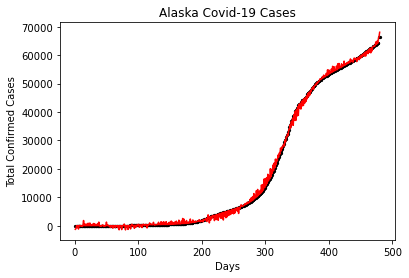

In [14]:
Alaska_MSE = StateLinearRegression("Alaska")


In [15]:
print('The Mean Square Error is', Alaska_MSE)

The Mean Square Error is 791133.5010716354
